In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
import pandas as pd
from collections import Counter
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from pathlib import Path
from urllib import request
from ppxf.ppxf import ppxf, robust_sigma
import ppxf.ppxf_util as util
import ppxf.sps_util as lib
from vorbin.voronoi_2d_binning import voronoi_2d_binning
from plotbin.display_bins import display_bins
from ppxf.ppxf_util import log_rebin
import os
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import math
import csv
from scipy import ndimage
import glob
from time import time 
from astropy.wcs import WCS

In [2]:
output_cubes='/home/sabrinadopico/Área de trabalho/análise3866/1-Cubesprep/'
output_voronoi='/home/sabrinadopico/Área de trabalho/análise3866/before/2-Voronoi/'

In [6]:
# Cálculo de S/N
hdul = fits.open(output_cubes+'maskedR.fits')
hdul.info()
header = hdul[0].header  
sci_data = hdul[0].data  # SCI
var_data = hdul[1].data  # VAR
hdul.close()
lambda_start = header['CRVAL3']
delta_lambda = header['CDELT3']
print(delta_lambda)
sci_array = np.array(sci_data) 
var_array = np.array(var_data)
z_dim, y_dim, x_dim = sci_array.shape
wavelengths = lambda_start + delta_lambda * np.arange(z_dim)
lambda_min_n2 = 6573
lambda_max_n2 = 6593
lambda_min_norm=6400
lambda_max_norm=6500

pixels2sum_n2 = np.where((wavelengths >= lambda_min_n2) & (wavelengths <= lambda_max_n2))[0]
pixels_norm_sum = np.where((wavelengths >= lambda_min_norm) & (wavelengths <= lambda_max_norm))[0]
n_pix_norm= len(sci_array[pixels_norm_sum,1,1])
print(n_pix_norm)
snr_map_n2 = np.zeros((sci_array.shape[1], sci_array.shape[2]))
total_signal_n2 = np.zeros((sci_array.shape[1], sci_array.shape[2]))
total_noise_n2 = np.zeros((sci_array.shape[1], sci_array.shape[2]))
total_noise_norm = np.zeros((sci_array.shape[1], sci_array.shape[2]))
for i in range(sci_array.shape[1]):  # Itera sobre a dimensão X
    for j in range(sci_array.shape[2]):  # Itera sobre a dimensão Y
        total_signal_n2[i, j] = np.sum(sci_array[pixels2sum_n2, i, j])
        total_noise_n2[i, j] = np.sqrt(np.sum(var_array[pixels2sum_n2, i, j]))
        total_noise_norm = np.std(sci_array[pixels_norm_sum, i, j])
        total_noise_norm_var=np.sqrt(np.sum(var_array[pixels_norm_sum, i, j]))
        total_noise_norm_var=total_noise_norm_var/np.sqrt(n_pix_norm)
        noise_ratio=total_noise_norm/total_noise_norm_var
        print(noise_ratio)
        total_noise_n2[i,j]=total_noise_n2[i,j]*noise_ratio
        if total_noise_n2[i, j] > 0:
            snr_map_n2[i, j] = total_signal_n2[i, j] / total_noise_n2[i, j]
        else:
            snr_map_n2[i, j] = np.nan
max_snr_hb = np.nanmax(snr_map_n2)

Filename: /home/sabrinadopico/Área de trabalho/análise3866/1-Cubesprep/maskedR.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      11   (33, 49, 4860)   float64   
  1  VAR           1 ImageHDU        13   (33, 49, 4860)   float64   
0.4908701256927088
204
0.25439072126056467
0.17870054060066282
0.17547711123441936
0.23274268154957528
0.16426073824728965
0.15708639049760303
0.23654462517480995
0.22287099169126112
0.15728563388943134
0.1791027209595665
0.24506553054664923
0.17584603856007835
0.18494275486052378
0.2541472595012583
0.20146112813597686
0.182168365857426
0.18610144828896716
0.24187798790901838
0.17459323201002805
0.17914675193158722
0.26061903198012915
0.19934503298221373
0.17997013551783828
0.23290657847964347
0.2648161116879153
0.17773036070615156
0.16328172400260665
0.2623863131072806
0.18765361211038348
0.15964114286876868
0.21523499723032863
0.2465704532824514
0.1794693569313325
0.18764206521050983
0.2629519818879715


O valor de SNR máximo no intervalo: 31.03738513549898


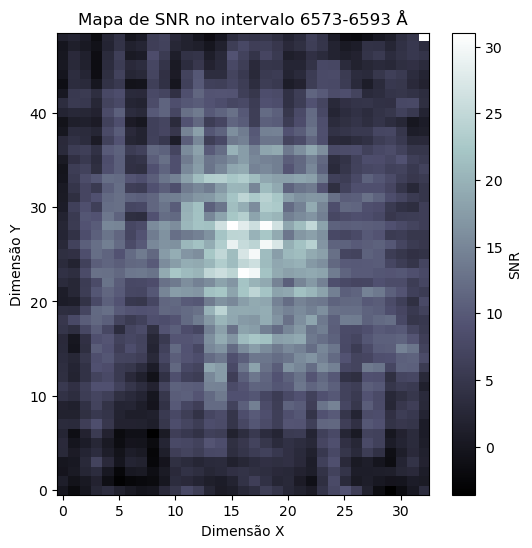

/home/sabrinadopico/anaconda3/lib/python3.10/site-packages/vorbin/voronoi_2d_binning.py:278: RuntimeWarning: invalid value encountered in sqrt
  scale[k] = np.sqrt(index.size/sn)  # Eq. (4) of Diehl & Statler (2006)


ValueError: operands could not be broadcast together with shapes (794,) (842,) 

In [8]:


print("O valor de SNR máximo no intervalo:", max_snr_hb)
plt.figure(figsize=(6, 6))
plt.imshow(snr_map_n2, cmap='bone', origin='lower', aspect='auto')
plt.colorbar(label='SNR')
plt.title(f'Mapa de SNR no intervalo {lambda_min_n2}-{lambda_max_n2} Å')
plt.xlabel('Dimensão X')
plt.ylabel('Dimensão Y')
plt.show()


# Voronoi e geração do arquivo txt
x_dim = sci_array.shape[2]
y_dim = sci_array.shape[1]
X, Y = np.meshgrid(np.arange(x_dim), np.arange(y_dim))
X = X.flatten()
Y = Y.flatten()
signal_n2_flat = total_signal_n2.flatten()
noise_n2_flat = total_noise_n2.flatten()
snr_n2 = snr_map_n2.flatten() 
mask = ~np.isnan(snr_n2)
X = X[mask]
Y = Y[mask]
signal_n2_flat = signal_n2_flat[mask]
noise_n2_flat = noise_n2_flat[mask]
targetSN = 10
result = voronoi_2d_binning(X, Y, signal_n2_flat, noise_n2_flat, targetSN)
binNum = result[0]
output = np.column_stack((X, Y, binNum))
output_file_path = os.path.join(output_voronoi, 'voronoi_n2.txt')
np.savetxt(output_file_path, output, header='X Y BIN_NUM', fmt='%10.5f %10.5f %8i')


### Plot Red e salvando o voronoi
y_dim, x_dim = sci_data.shape[1], sci_data.shape[2]
binning_file_path = output_voronoi+'voronoi_n2.txt'
binning_data = np.loadtxt(binning_file_path, skiprows=1)
X = binning_data[:, 0].astype(int)
Y = binning_data[:, 1].astype(int)
binNum = binning_data[:, 2].astype(int)
num_bins = np.max(binNum) + 1 # Aqui determina a quantidade de bins que foram definidos no voronoi
print(num_bins)
combined_sci_data = np.zeros((sci_data.shape[0], y_dim, x_dim)) # cria o novo cubo
combined_var_data = np.zeros((var_data.shape[0], y_dim, x_dim))
bin_filled = np.zeros((y_dim, x_dim), dtype=bool) # cria um array boleano para ver se os bins foram preenchidos com os dados combinados.

for bin_num in range(num_bins):
    mask = binNum == bin_num
    x_coords = X[mask]
    y_coords = Y[mask]
    if len(x_coords) == 0:
        continue
    bin_flux = np.zeros(sci_data.shape[0])
    bin_variance = np.zeros(var_data.shape[0])    
    for x, y in zip(x_coords, y_coords):
        bin_flux += sci_data[:, y, x]
        bin_variance += var_data[:, y, x]
    bin_flux /= len(x_coords)
    bin_variance /= len(x_coords)
    for x, y in zip(x_coords, y_coords):
        combined_sci_data[:, y, x] = bin_flux
        combined_var_data[:, y, x] = bin_variance
        bin_filled[y, x] = True
if not np.all(bin_filled):
    print("Existem pixels não preenchidos no mapa.")

output_fits_path = output_voronoi+'voronoiR.fits'
hdu_sci = fits.PrimaryHDU(data=combined_sci_data, header=header)
hdu_var = fits.ImageHDU(data=combined_var_data, name='VAR')

hdul = fits.HDUList([hdu_sci, hdu_var])
hdul.writeto(output_fits_path, overwrite=True)
print(binNum)
with fits.open(output_cubes+'maskedR.fits') as hdul_initial:
    data_initial = hdul_initial[0].data 
with fits.open(output_voronoi+'voronoiR.fits') as hdul_corrected:
    data_corrected = hdul_corrected[0].data
flux_map_initial = np.median(data_initial, axis=0)
flux_map_corrected = np.median(data_corrected, axis=0)
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

im1 = axs[0].imshow(flux_map_initial, origin='lower', cmap='bone')
axs[0].set_title('Mapa de Fluxo Inicial - Red')
fig.colorbar(im1, ax=axs[0], orientation='vertical')

im2 = axs[1].imshow(flux_map_corrected, origin='lower', cmap='bone')
axs[1].set_title('Mapa de Fluxo pós-voronoi - Red')
fig.colorbar(im2, ax=axs[1], orientation='vertical')

plt.tight_layout()
plt.show()

###### Plot Blue e salvando o voronoi
y_dim, x_dim = sci_data.shape[1], sci_data.shape[2]
binning_file_path = output_voronoi+'voronoi_n2.txt'
binning_data = np.loadtxt(binning_file_path, skiprows=1)
X = binning_data[:, 0].astype(int)
Y = binning_data[:, 1].astype(int)
binNum = binning_data[:, 2].astype(int)
num_bins = np.max(binNum) + 1 # Aqui determina a quantidade de bins que foram definidos no voronoi
print(num_bins)
hdul = fits.open(output_cubes+'maskedB.fits')
hdul.info()
header = hdul[0].header  
sci_data = hdul[0].data  # SCI
var_data = hdul[1].data  # VAR
hdul.close()
lambda_start = header['CRVAL3']
delta_lambda = header['CDELT3']
sci_array = np.array(sci_data) 
var_array = np.array(var_data)
z_dim, y_dim, x_dim = sci_array.shape
wavelengths = lambda_start + delta_lambda * np.arange(z_dim)
combined_sci_data = np.zeros((sci_data.shape[0], y_dim, x_dim)) # cria o novo cubo
combined_var_data = np.zeros((var_data.shape[0], y_dim, x_dim))
bin_filled = np.zeros((y_dim, x_dim), dtype=bool) # cria um array boleano para ver se os bins foram preenchidos com os dados combinados.

for bin_num in range(num_bins):
    mask = binNum == bin_num
    x_coords = X[mask]
    y_coords = Y[mask]
    if len(x_coords) == 0:
        continue
    bin_flux = np.zeros(sci_data.shape[0])
    bin_variance = np.zeros(var_data.shape[0])    
    for x, y in zip(x_coords, y_coords):
        bin_flux += sci_data[:, y, x]
        bin_variance += var_data[:, y, x]
    bin_flux /= len(x_coords)
    bin_variance /= len(x_coords)
    for x, y in zip(x_coords, y_coords):
        combined_sci_data[:, y, x] = bin_flux
        combined_var_data[:, y, x] = bin_variance
        bin_filled[y, x] = True
if not np.all(bin_filled):
    print("Existem pixels não preenchidos no mapa.")

output_fits_path = output_voronoi+'voronoiB.fits'
hdu_sci = fits.PrimaryHDU(data=combined_sci_data, header=header)
hdu_var = fits.ImageHDU(data=combined_var_data, name='VAR')

hdul = fits.HDUList([hdu_sci, hdu_var])
hdul.writeto(output_fits_path, overwrite=True)
print(binNum)
with fits.open(output_cubes+'maskedB.fits') as hdul_initial:
    data_initial = hdul_initial[0].data 
with fits.open(output_voronoi+'voronoiB.fits') as hdul_corrected:
    data_corrected = hdul_corrected[0].data
flux_map_initial = np.median(data_initial, axis=0)
flux_map_corrected = np.median(data_corrected, axis=0)
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

im1 = axs[0].imshow(flux_map_initial, origin='lower', cmap='cividis')
axs[0].set_title('')
fig.colorbar(im1, ax=axs[0], orientation='vertical')

im2 = axs[1].imshow(flux_map_corrected, origin='lower', cmap='cividis')
axs[1].set_title('')
fig.colorbar(im2, ax=axs[1], orientation='vertical')

plt.tight_layout()
plt.show()